In [1]:
import os
import torch
#from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Custom dataset class
class CustomLogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for label, subdir in enumerate(['Fake', 'Genuine']):
            folder_path = os.path.join(self.root_dir, subdir)
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    self.images.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Load the trained model
def load_trained_model(model_path):
    model = models.inception_v3(pretrained=False)
    num_classes = 2
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\Python\Python39\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


              precision    recall  f1-score   support

        Fake       0.99      0.71      0.83       110
     Genuine       0.63      0.98      0.77        55

    accuracy                           0.80       165
   macro avg       0.81      0.85      0.80       165
weighted avg       0.87      0.80      0.81       165



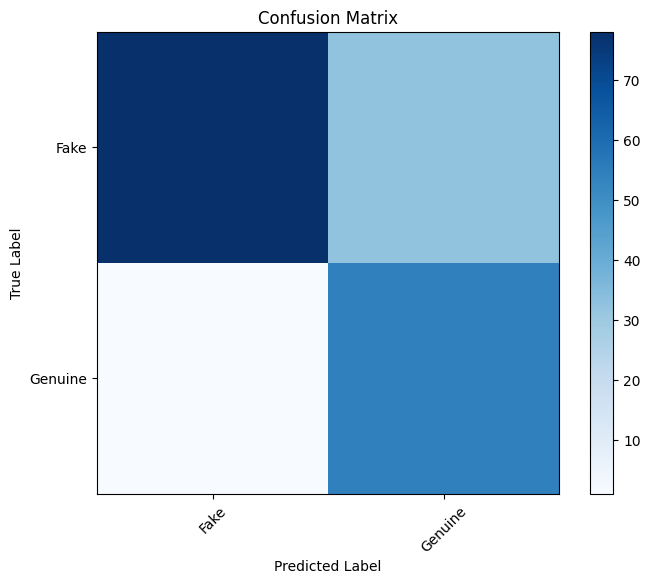

In [4]:


# --- Step 1: Import Libraries --- (already done) 

# --- Step 2: Load Dataset and Trained Model ---

# Dataset Configuration
data_dir = 'FakeReal Logo Detection dataset/test'  # Path to your test dataset
image_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),
])

# Create Dataset and Dataloader
test_dataset = CustomLogoDataset(data_dir, transform=image_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load Pre-trained Model
model_path = 'inception_fake_real_logo_detection_model_second.pth'
model = load_trained_model(model_path)  # You'll need your load_trained_model function 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- Step 3: Collect Predictions ---
# def collect_predictions(model, dataloader, device):
#     true_labels = []
#     predicted_labels = []

#     model.eval()

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)  

#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())

#     return true_labels, predicted_labels
def collect_predictions(model, dataloader, device):
    true_labels = []
    predicted_labels = []
    predicted_scores = []  # Add a list to store scores

    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get predicted scores (probabilities)
            predicted_scores.extend(outputs[:, 1].cpu().numpy())  # Assuming 'Genuine' is the second column

            _, predicted = torch.max(outputs.data, 1)  

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    return true_labels, predicted_labels, predicted_scores  # Return scores


#true_labels, predicted_labels = collect_predictions(model, test_dataloader, device)
true_labels, predicted_labels,predicted_scores = collect_predictions(model, test_dataloader, device)

# --- Step 4: Calculate Classification Report ---
target_names = ['Fake', 'Genuine'] 
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# --- Step 5: Plot Confusion Matrix (Optional)---
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [5]:
# def collect_predictions(model, dataloader, device):
#     true_labels = []
#     predicted_labels = []
#     predicted_scores = []  # Add a list to store scores

#     model.eval()

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)

#             # Get predicted scores (probabilities)
#             predicted_scores.extend(outputs[:, 1].cpu().numpy())  # Assuming 'Genuine' is the second column

#             _, predicted = torch.max(outputs.data, 1)  

#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())

#     return true_labels, predicted_labels, predicted_scores  # Return scores


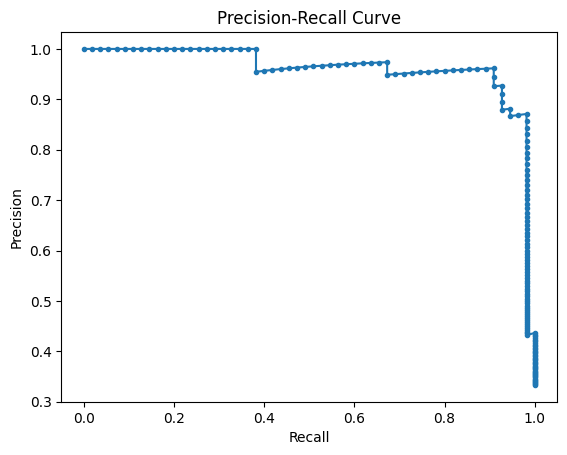

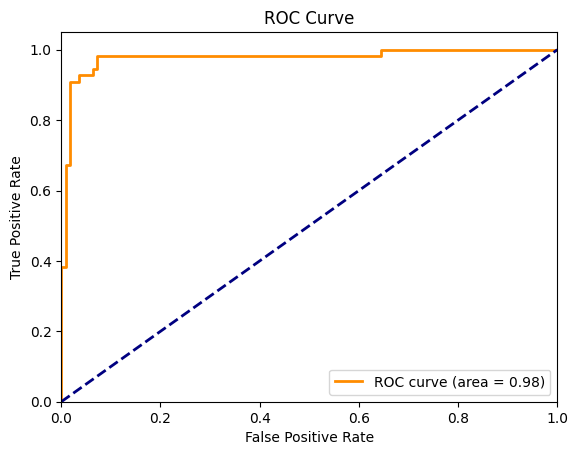

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

# ... (Your existing code for CustomLogoDataset, load_trained_model, data loading, prediction collection)

# ... (Your code for classification report and confusion matrix) 
true_labels, predicted_labels,predicted_scores = collect_predictions(model, test_dataloader, device)
# --- Step 6: Plot Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(true_labels, predicted_scores)
plt.figure()  # Create a new figure for the plots
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# --- Step 7: Plot ROC Curve ---
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # No-skill line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# # --- Step 8: Plot Class Prediction Errors (Example) ---
# def plot_prediction_errors(images, true_labels, predicted_labels, transform):
#     """Displays images that were incorrectly classified."""
#     incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predicted_labels[i]]
#     num_images = min(10, len(incorrect_indices))  # Display up to 10 errors

#     fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6)) 
#     axes = axes.flatten()

#     for i, idx in enumerate(incorrect_indices[:num_images]):
#         image = images[idx]
#         true_class = target_names[true_labels[idx]]
#         predicted_class = target_names[predicted_labels[idx]]

#         if transform:
#             image = transform.transforms[0].inverse(image)  # Inverse of Resize 

#         axes[i].imshow(image.permute(1, 2, 0).numpy()) 
#         axes[i].set_title(f"True: {true_class}, Pred: {predicted_class}")
#         axes[i].axis('off')

#     plt.tight_layout()
#     plt.show()


# # Assuming you have your predicted scores


# #predicted_scores = []
# with torch.no_grad():
#     for images, labels in test_dataset:
#         images = images.unsqueeze(0).to(device)
#         outputs = model(images)
#         predicted_scores.extend(outputs[:, 1].cpu().numpy())  # Assuming 2nd column is 'Genuine'

# plot_prediction_errors(test_dataset.images, true_labels, predicted_labels, image_transforms) 


In [7]:
class CustomLogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  # Will now store PIL Image objects
        self.labels = []
        for label, subdir in enumerate(['Fake', 'Genuine']):
            folder_path = os.path.join(self.root_dir, subdir)
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(folder_path, filename)
                    image = Image.open(img_path).convert('RGB')  # Load here
                    self.images.append(image) 
                    self.labels.append(label)

    # ... (Rest of your Dataset code: __len__, __getitem__) 
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


AttributeError: 'str' object has no attribute 'convert'

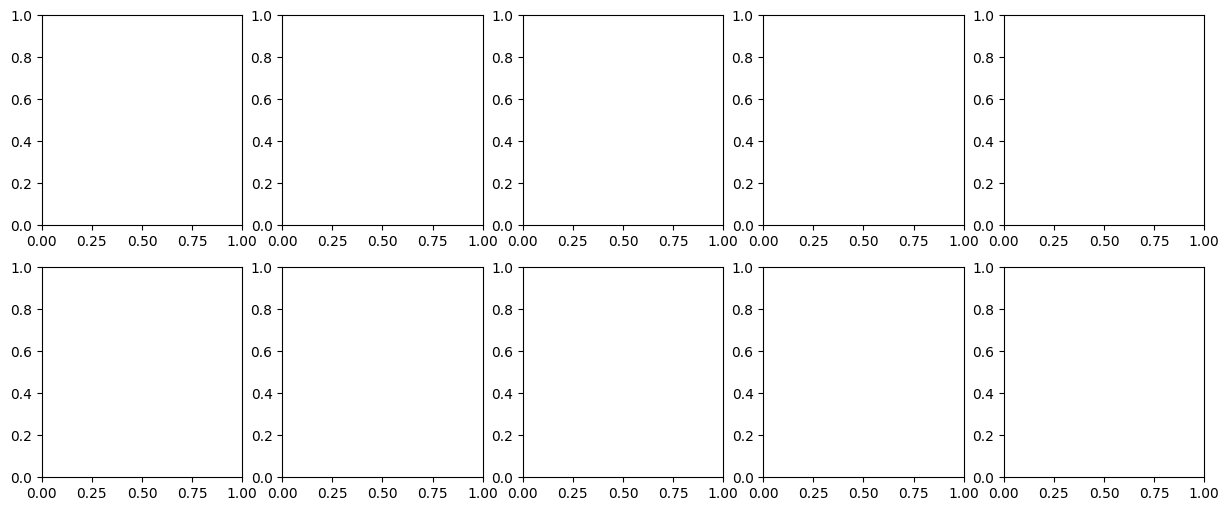

In [8]:
import torchvision.transforms.functional as F  # Import for upsampling

def plot_prediction_errors(images, true_labels, predicted_labels, transform):
    """Displays images that were incorrectly classified."""
    incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predicted_labels[i]]
    num_images = min(10, len(incorrect_indices))  # Display up to 10 errors

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6)) 
    axes = axes.flatten()

    for i, idx in enumerate(incorrect_indices[:num_images]):
        image = images[idx]  # Assuming PIL Image here
        true_class = target_names[true_labels[idx]]
        predicted_class = target_names[predicted_labels[idx]]

        if transform:
            image = image.convert("RGB")  # Make sure it's RGB for upsampling
            original_size = image.size  # Store the original dimensions
            image = transform(image)  # Apply the transforms (including resizing)
            image = F.resize(image, original_size, interpolation=F.InterpolationMode.BILINEAR)  # Upscale

        axes[i].imshow(image.permute(1, 2, 0).numpy()) 
        axes[i].set_title(f"True: {true_class}, Pred: {predicted_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


with torch.no_grad():
    for images, labels in test_dataset:
        images = images.unsqueeze(0).to(device)
        outputs = model(images)
        predicted_scores.extend(outputs[:, 1].cpu().numpy())  # Assuming 2nd column is 'Genuine'

plot_prediction_errors(test_dataset.images, true_labels, predicted_labels, image_transforms) 
